# Example notebook: pipeline walkthrough

This notebook walks through the process of generating a Roman WFI image of a strong lens starting with its parameterization in `lenstronomy`.

In [1]:
import astropy.cosmology as astropy_cosmo
import matplotlib.pyplot as plt
import numpy as np
from pyHalo.preset_models import CDM

from mejiro.lenses.strong_lens import StrongLens
from mejiro.helpers import gs, color

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-065 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-068
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


# Set up a strong lens in `lenstronomy`

Below is a sample strong lens in `lenstronomy` format, based upon a strong lens from our Roman HLWAS survey simulation.

The minimum requirements to generate an image with this pipeline are:
* `kwargs_params`
* `kwargs_model`
    * While the redshift-related attributes are not always required to generate an image in `lenstronomy`, they are required for this pipeline (e.g. `pyHalo` generates redshift-dependent subhalo populations).
    * The `cosmo` attribute should be set to `astropy_cosmo.default_cosmology.get()` which provides Plank18 cosmology. This is the cosmology used in other parts of the pipeline and this value is not passed through, so to be in agreement with the rest of the pipeline (both upstream in the `SkyPy`/`SLSim` survey simulation and downstream by `pyHalo`), this value should stay constant. This may be addressed in a future update.
* AB Magnitude(s) of the source and lensing galaxies in at least one filter, stored in dictionaries `lens_mags` and `source_mags`

In [2]:
z_lens = 0.2902115249535011
z_source = 0.5876899931818929

lens_stellar_mass = 286796906929.3925  # solar masses
lens_velocity_dispersion = 295.97270864848  # km/s

kwargs_lens = [{'center_x': -0.007876281728887604,
                'center_y': 0.010633393703246008,
                'e1': 0.004858808997848661,
                'e2': 0.0075210751726143355,
                'theta_E': 1.168082477232392},
               {'dec_0': 0,
                'gamma1': -0.03648819840013156,
                'gamma2': -0.06511863424492038,
                'ra_0': 0},
               {'dec_0': 0, 'kappa': 0.06020941823541971, 'ra_0': 0}]

kwargs_lens_light = [{'R_sersic': 0.5300707454127908,
                      'center_x': -0.007876281728887604,
                      'center_y': 0.010633393703246008,
                      'e1': 0.023377277902774978,
                      'e2': 0.05349948216860632,
                      'magnitude': 17.5664222662219,
                      'n_sersic': 4.0}]

kwargs_source = [{'R_sersic': 0.1651633078964498,
                  'center_x': 0.30298310338567075,
                  'center_y': -0.3505004565139597,
                  'e1': -0.06350855238708408,
                  'e2': -0.08420760408362458,
                  'magnitude': 21.434711611915137,
                  'n_sersic': 1.0}]

hlwas_bands = ['F106', 'F129', 'F184']

lens_mags = {
    'F106': 17.5664222662219,
    'F129': 17.269983557132853,
    'F184': 17.00761457389914
}

source_mags = {
    'F106': 21.434711611915137,
    'F129': 21.121205893763328,
    'F184': 20.542431041034558
}

kwargs_params = {
    'kwargs_lens': kwargs_lens,
    'kwargs_lens_light': kwargs_lens_light,
    'kwargs_source': kwargs_source
}

kwargs_model = {
    'cosmo': astropy_cosmo.default_cosmology.get(),
    'lens_light_model_list': ['SERSIC_ELLIPSE'],
    'lens_model_list': ['SIE', 'SHEAR', 'CONVERGENCE'],
    'lens_redshift_list': [z_lens] * 3,
    'source_light_model_list': ['SERSIC_ELLIPSE'],
    'source_redshift_list': [z_source],
    'z_source': z_source,
    'z_source_convention': 5.
}

The `StrongLens` object below is simply a way to keep track of this strong lens, with associated attributes and methods.

In [3]:
strong_lens = StrongLens(kwargs_model=kwargs_model,
                         kwargs_params=kwargs_params,
                         lens_mags=lens_mags,
                         source_mags=source_mags,
                         lens_stellar_mass=lens_stellar_mass,
                         lens_vel_disp=lens_velocity_dispersion)

# Add subhalos with `pyhalo`

First, generate a population of CDM subhalos.

Note that `pyhalo` supports a broad range of dark matter models (see its [example notebooks](https://github.com/dangilman/pyHalo/tree/master/example_notebooks)). For instance, once could replace the `CDM` preset model below with the `WDM` preset model to generate a population of warm dark matter subhalos.

In [4]:
z_lens = round(strong_lens.z_lens, 2)
z_source = round(strong_lens.z_source, 2)
log_m_host = np.log10(strong_lens.main_halo_mass)
print(
    f'Generating CDM subhalos for lensing galaxy at z={z_lens} and source galaxy at z={z_source} with main halo mass {log_m_host:.2f}' + r' $\log_{10}(M_\odot)$')

realization = CDM(z_lens,
                  z_source,  # pyHalo wants to source redshift to generate line-of-sight halos
                  sigma_sub=0.055,
                  cone_opening_angle_arcsec=5.,
                  LOS_normalization=0.,  # here's where we exclude line-of-sight halos
                  log_mlow=6.,
                  log_mhigh=10.,
                  log_m_host=log_m_host,
                  r_tidal=0.5)

Generating CDM subhalos for lensing galaxy at z=0.29 and source galaxy at z=0.59 with main halo mass 13.53 $\log_{10}(M_\odot)$


`pyhalo` has nice plotting routines to easily visualize the properties of this unique subhalo population - [from `pyhalo`'s "Basic usage" Jupyter notebook](https://github.com/dangilman/pyHalo/blob/master/example_notebooks/basic_usage.ipynb):

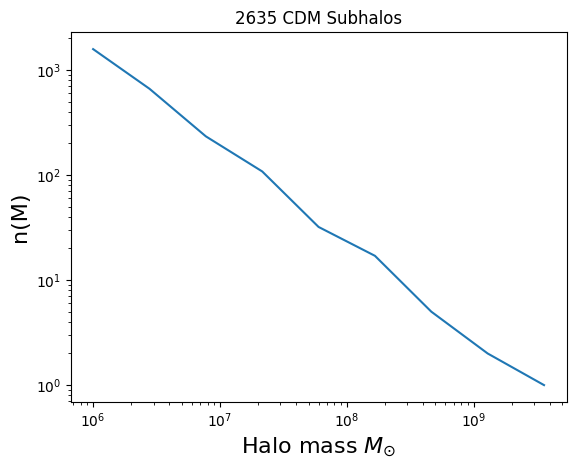

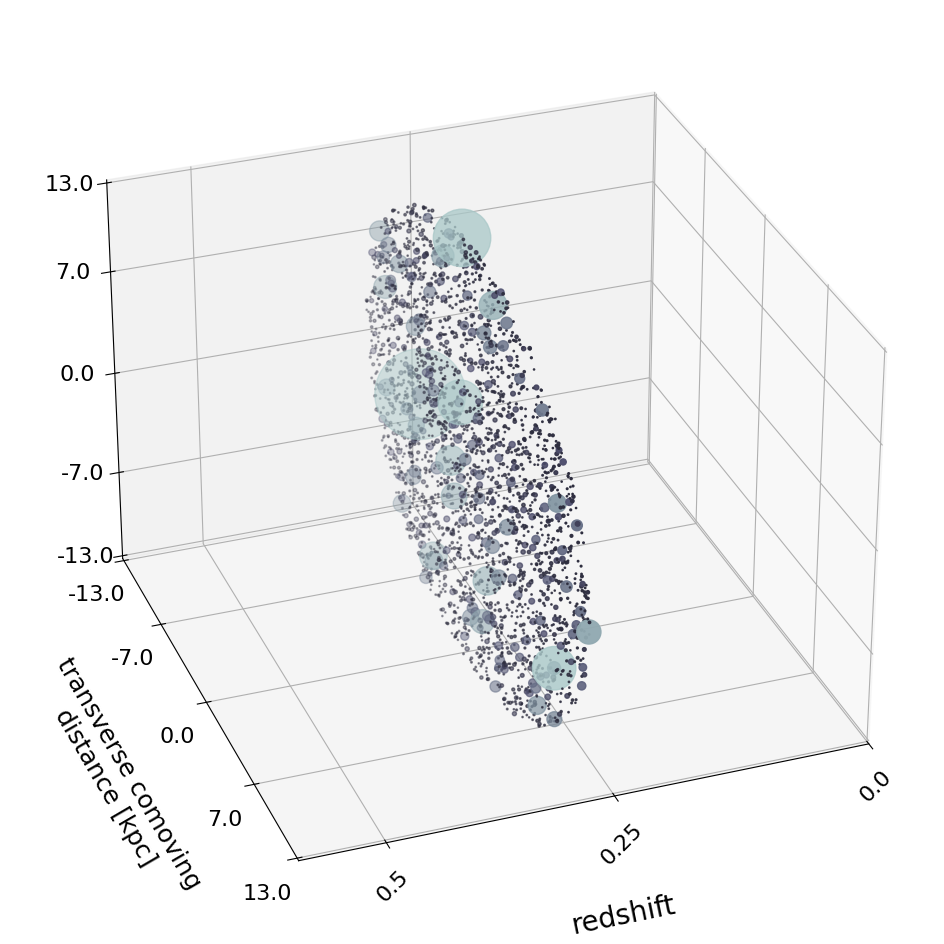

In [5]:
cdm_halo_masses = [halo.mass for halo in realization.halos]
num_subhalos = len(cdm_halo_masses)
N, m = np.histogram(cdm_halo_masses, bins=np.logspace(6, 10, 10))

fig = plt.figure(1)
ax = plt.subplot(111)
ax.loglog(m[0:-1], N)
ax.set_xlabel('Halo mass ' + r'$M_{\odot}$', fontsize=16)
ax.set_ylabel('n(M)', fontsize=16)
ax.set_title(f'{num_subhalos} CDM Subhalos')

fig = plt.figure(figsize=(14, 12))
ax = plt.subplot(111, projection='3d')
realization.plot(ax)

Add this subhalo population to the strong lens model.

In [6]:
strong_lens.add_subhalos(realization)

# Produce the synthetic image

This "synthetic image" has no PSF convolution or noise. An arbitrarily upsampled version can be rendered to create a more detailed input to `galsim`.

Note that we will ultimately produce a 45x45 pixel (or 4.95"x4.95") image but here we render an image that's 51x51 pixels (or 5.61"x5.61"). Inputting a larger scene than what `mejiro` will output, with a 3 pixel (or 0.33") buffer around the entire image, ensures any flux on the edges of the scene is rendered correctly in the final image (e.g., cutting off the border artificially created by the `galsim` method that applies the effect of intrapixel capacitance).

Note also that this clunky method of synthetic image generation will be refactored in `mejiro`>=2.0.0.

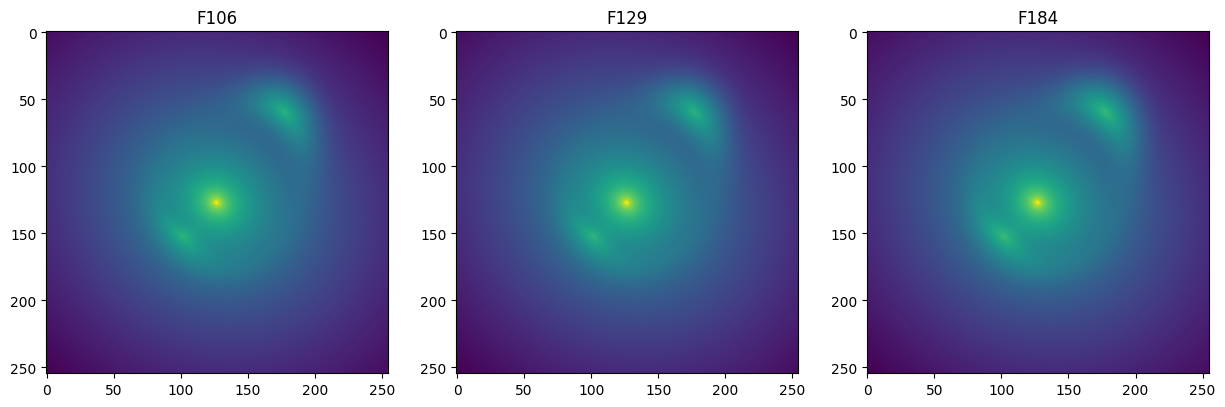

In [7]:
supersample = 5
strong_lens.side = 5.61
strong_lens.num_pix = 51 * supersample
supersampled_indices = strong_lens.build_adaptive_grid(51 * supersample, pad=25)
kwargs_numerics = {
    'supersampling_factor': 3,
    'compute_mode': 'adaptive',
    'supersampled_indexes': supersampled_indices
}

models = [strong_lens.get_array(num_pix=51 * supersample, side=5.61, band=band, kwargs_numerics=kwargs_numerics) for
          band in hlwas_bands]

f, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, a in enumerate(ax):
    a.imshow(np.log10(models[i]))
    a.set_title(hlwas_bands[i])
plt.show()

The important pixels where the subhalo signal is are being further supersampled by a factor of three. This is being accomplished with the `kwargs_numerics` dict. Below, we can see which pixels are being further supersampled.

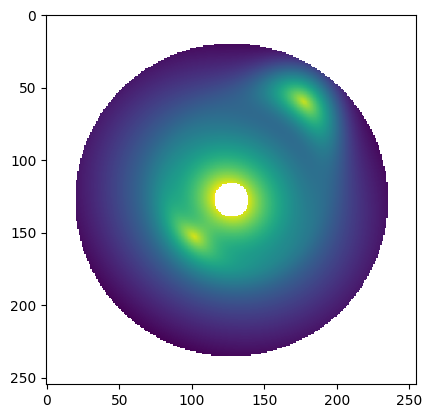

In [8]:
plt.imshow(np.where(supersampled_indices, np.log10(models[0]), np.nan))
plt.show()

# Apply PSF convolution, sky background, and Roman detector effects

First, determine the specific detector (SCA) and position on that detector that will define the center of the image. See the [WebbPSF documentation](https://webbpsf.readthedocs.io/en/latest/roman.html) for the details on what these numbers mean, where `detector` is fed into `wfi.detector` and `detector_pos` into `wfi.detector_position`.

In [9]:
detector = gs.get_random_detector()
detector_pos = gs.get_random_detector_pos(input_size=models[0].shape[0], oversample=supersample)

Detector: 10
Detector position: 1410, 1993


Generated image(s) in 0:01:07


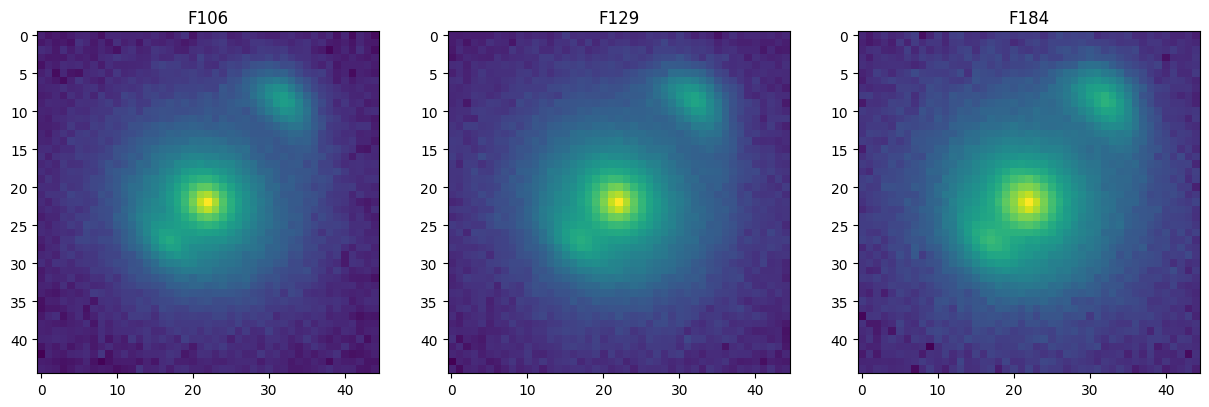

In [10]:
results, execution_time = gs.get_images(strong_lens,
                                        models,
                                        hlwas_bands,
                                        input_size=51,  # size of the input image, in pixels
                                        output_size=45,  # size of the output image, in pixels
                                        grid_oversample=supersample,
                                        psf_oversample=supersample,
                                        detector=detector,
                                        detector_pos=detector_pos,
                                        exposure_time=146,  # seconds
                                        seed=np.random.randint(0, 2 ** 16 - 1),
                                        check_cache=False)

print(f'Generated image(s) in {execution_time}')

f, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, a in enumerate(ax):
    a.imshow(np.log10(results[i]))
    a.set_title(hlwas_bands[i])
plt.show()

Note that a majority of the computation time of the cell above is WebbPSF generating the PSFs for each band at the specified location.

# Combine into a color image

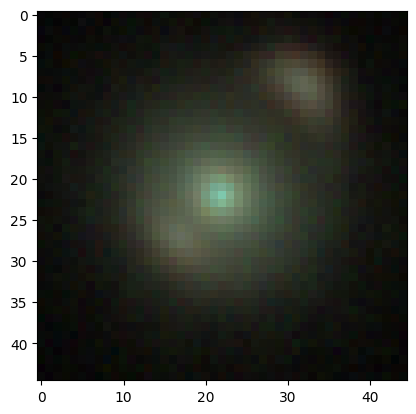

In [11]:
rgb_image = color.get_rgb(image_b=results[0],
                          image_g=results[1],
                          image_r=results[2],
                          stretch=8,
                          Q=10)

plt.imshow(rgb_image)
plt.show()